# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Content
- [Exploratory Data Analysis Part 1](#Exploratory_Data_Analysis1)<br>
    - [DataFrame preliminary Description](#describe_df)<br>
    - [Study DataFrame for based on userId](#df_example_study)<br>
- [Data Preparation](#data_prep)<br>
    - [Drop missing/uncommon values](#filter_data)<br>
    - [Define Churn - The Label for Machine Learning Modeling](#churn)<br>
    - [Distribution of churned and non churned users](#Distribution_of_churned_and_non_churned_users)<br> 
- [Exploratory Data Analysis Part 2](#Exploratory_Data_Analysis2)<br>
    - [Gender distribution based on churn](#Gender_distribution_based_on_churn)
    - [Membership duration](#member_dur)
    - [Total page activity based on churn](#Total_page_activity_based_on_churn)<br>
    - [Total number of songs played by user](#total_number_of_songs_played_by_user)<br>
    - [Average number of songs played per user per session](#Average_number_of_songs_played_by_user_per_session)<br>
    - [Total number of thumbs up per user](#total_number_of_thumbs_up_per_user)<br>
    - [Total number of thumbs down per user](#total_number_of_thumbs_down_per_user)<br>
    - [Total number of errors per user](#Total_number_of_errors_per_user)<br>
    - [Total number of "Add to Playlist" clicks per user](#Total_number_of_Add_to_playlist_clicks_per_user)<br>
    - [Total number of "Add Friend" clicks per user](#Total_number_of_Add_Friend_clicks_per_user)<br>
    - [Feature report](#feature_report)
    
- [Feature Engineering](#Feature_Engineering)<br> 
- [Modeling](#modeling)<br> 
- [Evaluation](#evaluation)<br>

In [9]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum,  min, max
import pyspark.sql.functions as psqf
from pyspark.sql.functions import col, countDistinct,  mean as _mean, stddev as _stddev
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics


import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))

In [10]:
# get back the used libraries and their versions as a list of tuples
import pkg_resources
import types
def get_imports():
    """ Get a list of packages and versions for README.md
    
        INPUTS: 
        -----------
            None

        OUTPUTS: 
        -----------
            list of tuples with package names and tuples
    """
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
        
imports = list(set(get_imports()))

# Get the versions of the root package
# by cross-checking the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
        
printmd('### The additional library requirements to run this notebook')
print(requirements)

### The additional library requirements to run this notebook

[('pyspark', '2.4.3'), ('seaborn', '0.8.1'), ('pandas', '0.23.3'), ('numpy', '1.12.1'), ('matplotlib', '2.1.0')]


In [11]:
# Some UDF needed in the notebook

# Convert timestamps to datetime from epoch time to get the hour of the day. Create a user defined function called get_hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

# Convert epoch time in milliseconds to econds
get_seconds = udf(lambda x: x / 1000.0)

# Convert epoch time in milliseconds to days
get_days = udf(lambda x: x / (1000.0 * 3600 * 24))

In [12]:
def plot_sns_bar(x, y, data, hue=None, log=False, title='', xlabel='x', ylabel='y', legend='', figsize=(8,5), save=False, hide_xtick=False, rotation=0, order=False, sort_by='', ascending=False):
    """ plot sns bar plot
        INPUTS:
        ------------
            x - (string) column name of DataFrame used as xaxis
            y - (string) column name of DataFrame used as yaxis
            hue - (string) grouping variable 
            data - (pandas dataframe) dataframe used fot plotting
            log - (bool) if True use logarithmic scale for y axis, else linear 
            title - (string) title of plot
            xlabel - (string) xlabel name 
            ylabel - (string) ylabel name
            save - (bool) if True save plot as png
            hide_xtick - (bool) if True hide xtick labels
            rotation - (int) angle in degrees forxlabel rotation
            order - (bool) if True order xaxis by sort_by
            sort_by (string) name of dataframe column for which xaxis should be ordered
            ascending - (bool) if True use ascending order for sort
                            
     
        OUTPUTS:
        ------------
            No return
            seaborn plot 
            png export 
            
    """
    fig = plt.figure(figsize=figsize)
    # make barplot and sort bars
    if order == True:
        g1 = sns.barplot(x=x,
                    y=y, 
                    data=data, 
                    log=log,
                    hue=hue,
                    order=data.sort_values(sort_by, ascending=ascending)[x])
    else:
        g1 = sns.barplot(x=x,
                    y=y, 
                    data=data,
                    log=log,
                    hue=hue)
        
    # set labels
    if hide_xtick == True:
        g1.set(xticklabels=[])  # remove the tick labels
    plt.xlabel(xlabel, size=15)
    plt.ylabel(ylabel, size=15)
    plt.xticks(rotation=rotation)
    plt.title(title, size=18)
    if legend !='':
        plt.legend(title=legend, loc='best')
    plt.tight_layout()
    if save == True:
        name = title.replace(' ', '_')
        plt.savefig(name + ".png", dpi=100)
        

In [13]:
def plot_sns_box(x, y, data, title='', xlabel='x', ylabel='y', legend='', figsize=(8,5), save=False, hide_xtick=False, rotation=0, order=False, sort_by='', ascending=False):
    """ plot sns bar plot
        INPUTS:
        ------------
            x - (string) column name of DataFrame used as xaxis
            y - (string) column name of DataFrame used as yaxis
            hue - (string) grouping variable 
            data - (pandas dataframe) dataframe used fot plotting
            log - (bool) if True use logarithmic scale for y axis, else linear 
            title - (string) title of plot
            xlabel - (string) xlabel name 
            ylabel - (string) ylabel name
            save - (bool) if True save plot as png
            hide_xtick - (bool) if True hide xtick labels
            rotation - (int) angle in degrees forxlabel rotation
            order - (bool) if True order xaxis by sort_by
            sort_by (string) name of dataframe column for which xaxis should be ordered
            ascending - (bool) if True use ascending order for sort
                            
     
        OUTPUTS:
        ------------
            No return
            seaborn plot 
            png export 
            
    """
    fig = plt.figure(figsize=figsize)
    # make barplot and sort bars
    if order == True:
        g1 = sns.boxplot(x=x,
                    y=y, 
                    data=data, 
                    order=data.sort_values(sort_by, ascending=ascending)[x])
    else:
        g1 = sns.boxplot(x=x,
                    y=y, 
                    data=data)
                    
        
    # set labels
    if hide_xtick == True:
        g1.set(xticklabels=[])  # remove the tick labels
    plt.xlabel(xlabel, size=15)
    plt.ylabel(ylabel, size=15)
    plt.xticks(rotation=rotation)
    plt.title(title, size=18)
    if legend !='':
        plt.legend(title=legend, loc='best')
    plt.tight_layout()
    if save == True:
        name = title.replace(' ', '_')
        plt.savefig(name + ".png", dpi=100)
        

In [14]:
def plot_sns_distplot(data, column_to_plot, title='', xlabel='x', ylabel='y',  figsize=(8,5), save=False, bins=20, kde=True, norm_hist=True):
    fig = plt.figure(figsize=figsize)
    # make barplot and sort bars
    g1 = sns.distplot(data[column_to_plot], bins=bins, kde=kde, norm_hist=norm_hist)
    # set labels
    plt.xlabel(xlabel, size=15)
    plt.ylabel(ylabel, size=15)
    plt.title(title, size=18)
    plt.tight_layout()
    if save == True:
        name = title.replace(' ', '_')
        plt.savefig(name + ".png", dpi=100)

In [15]:
def plot_pie(df, title, explode, **kwargs):
    """
    INPUT:
        - df - dataframe to be plotted as a pie plot, columns of df --> the pie pieces of the plot
        - title - provide a title as string for the plot
        - explode - listto set the explosion of each pie piece, length must be equal to number of pie pieces
        - **kwargs - (optional) paramters to overwrite the default setting of the pie_setting_dict 
    OUTPUT:
        - A pie chart with a specially designed layout
    
    AIM:
        1.) Overwrite the default setting of the pie_setting_dict dictionary
        2.) execute plot_df.plot_df_bar() - this function will then create the plot based on the provided settings
    """
    pie_setting_dict = {'figsize' : (10,5),
                        'shadow' : True,
                        'autopct' : '%1.1f%%',
                        'startangle' :90,
                        'fontsize_title' : 14,
                        'fontsize_text' : 14,
                        'fontsize_legend' : 14,
                        'legend_state' : True,
                        'legend_title' : '',   
                        'legend_list_to_plot' : '',
                        'legend_move' : False,
                        'legend_x' : None,
                        'legend_y' : None}
    
    for key, value in kwargs.items():
        pie_setting_dict[key] = value
    plot_df.plot_df_pie(df, title, explode, pie_setting_dict)


In [16]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [17]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

# <a class="anchor" id="Exploratory_Data_Analysis1">Exploratory Data Analysis Part 1</a>
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## <a class="anchor" id="describe_df">DataFrame preliminary Description</a>

In [18]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [19]:
# Readable dataframe head using pandas
df_pd = df.toPandas()
df_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### Shape of DataFrame

In [20]:
printmd('#### Number of entries: ' + str(df.count()))
printmd('#### Number of columns: ' + str(len(df.columns)))

#### Number of entries: 286500

#### Number of columns: 18

### Describe the Dataframe

In [21]:
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


### Check for unique values

In [22]:
# count for unique value for each column
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status|    ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+
| 17655|   4|      189|     2|         1322|     173| 14865|    2|     114|     2|  22|         225|     2354|58480|     3|277447|       56|   226|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+



### Check for missing values

In [23]:
# count null values for each column
df_nulls = df.select([psqf.count(psqf.when(psqf.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



### Result: 
There are:
- 286500 entries in the dataset
- 226 unique users, 189 unique last names and 56 unique first names.
- 2354 unique seeionIds.
- 8346 users without first and last name and without gender. They seem to be anonymous.
- 0 null userIds
- 0 null sessionIds

### Check for uncommon entries: userId and sessionId

In [24]:
# Missing userID
number_missing_values = df.count() - df.dropna(how = "any", subset = ["userId", "sessionId"]).count()

In [25]:
printmd('#### There are ' + str(number_missing_values) + ' missing values for userId and sessionId')

#### There are 0 missing values for userId and sessionId

In [26]:
df.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [27]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [28]:
empty_string_user = df[df["userId"] == ""]

In [29]:
number_empty_string_user = empty_string_user.count()

In [30]:
printmd('#### There are '+ str(number_empty_string_user) + ' userId with empty string')

#### There are 8346 userId with empty string

In [31]:
df.select(["userId", "firstName", "lastName", "gender", "level"]).where(df.userId== "").show()

+------+---------+--------+------+-----+
|userId|firstName|lastName|gender|level|
+------+---------+--------+------+-----+
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
+------+---------+--------+------+-----+
only showing top

In [32]:
df.select(["userId", "firstName", "lastName", "gender"]).where(df.userId== "").dropDuplicates().show()

+------+---------+--------+------+
|userId|firstName|lastName|gender|
+------+---------+--------+------+
|      |     null|    null|  null|
+------+---------+--------+------+



In [33]:
df.select(["userId", "firstName", "lastName", "gender"]).where(df.userId== "").count()

8346

In [34]:
df.select(["userId", "firstName", "lastName", "gender", "level"]).where(df.userId== "").count()

8346

#### Result: 
- All users with "empty string" userId did not provide their first name, last name and gender. 
- They are anonymous and free users. 

### For the registered users: How many paid/free accounts are there?

In [35]:
num_paid_accounts = df.drop_duplicates(subset=['userId']).where(df.level =="paid").count()
printmd('#### There are ' + str(num_paid_accounts) + ' paid accounts')

#### There are 48 paid accounts

In [36]:
num_free_accounts = df.drop_duplicates(subset=['userId']).where(df.level =="free").count()
printmd('#### There are ' + str(num_free_accounts) + ' free accounts')

#### There are 178 free accounts

,account_type,count
0,paid,48
1,free,178


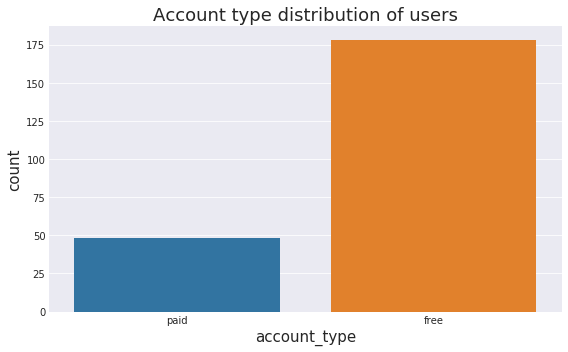

In [37]:
accountType_distribution_pd = pd.DataFrame({'account_type': ['paid', 'free'], 'count': [num_paid_accounts, num_free_accounts]})
display(accountType_distribution_pd)

plot_sns_bar(x='account_type',
             y='count', 
             data=accountType_distribution_pd, 
             title='Account type distribution of users', 
             xlabel='account_type', 
             ylabel='count', 
             save=True, 
             hide_xtick=False, 
             order=False)

### What are the web pages a user can visit?

In [38]:
df.select("page").dropDuplicates().sort("page").show(n=50)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [39]:
page_elements = df.select("page").dropDuplicates().rdd.flatMap(lambda x: x).collect()

### Total page activity count

In [40]:
total_page_activity_count = df.select('userId', 'page').groupby('page').count()
total_page_activity_count.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
+--------------------+------+
only showing top 20 rows



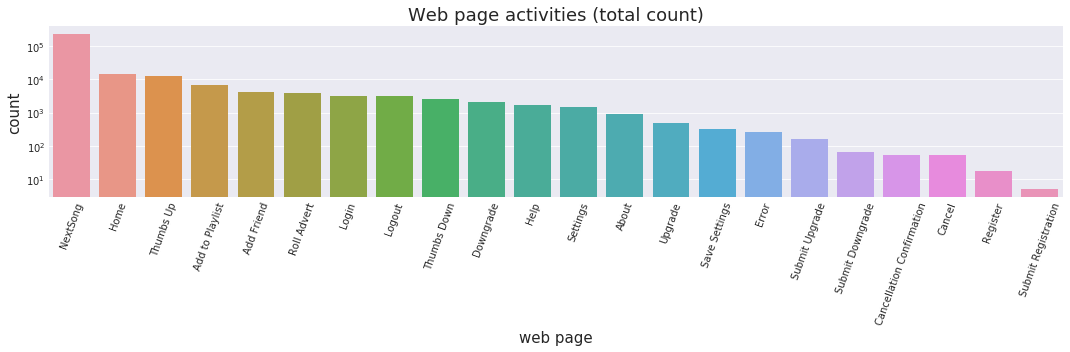

In [41]:
total_page_activity_count_pd = total_page_activity_count.toPandas()

plot_sns_bar(x='page',
             y='count', 
             data=total_page_activity_count_pd, 
             log=True, 
             title='Web page activities (total count)', 
             xlabel='web page', 
             ylabel='count', 
             figsize=(15,5),
             save=True, 
             hide_xtick=False, 
             rotation=70, 
             order=True, 
             sort_by='count', 
             ascending=False)

### Total number of songs played

In [42]:
df.where(df.page=='NextSong').count()

228108

## <a class="anchor" id="df_example_study">Study DataFrame for based on userId</a>

- Study the the DataFrame based on a provided userId. 
- Change the **userId in the next cell** to test different users

In [43]:
userId = 131

### Overview

In [44]:
# Overview
df.where(df.userId==userId).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Metallica,Logged In,Kael,M,0,Baker,415.16363,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Fade To Black,200,1538384355000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
1,Pearl Jam,Logged In,Kael,M,1,Baker,276.40118,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Nothingman (Live),200,1538384770000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
2,Frumpies,Logged In,Kael,M,2,Baker,134.47791,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Fuck Kitty,200,1538385046000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
3,Kaiser Chiefs,Logged In,Kael,M,3,Baker,222.82404,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Half The Truth,200,1538385180000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
4,Kelly Clarkson,Logged In,Kael,M,4,Baker,156.65587,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,(You Make Me Feel Like A) Natural Woman,200,1538385402000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
5,Darude,Logged In,Kael,M,5,Baker,516.28363,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Feel The Beat,200,1538385558000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
6,Bloc Party,Logged In,Kael,M,6,Baker,235.65016,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Luno,200,1538386074000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
7,Helen Reddy,Logged In,Kael,M,7,Baker,211.35628,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Angie Baby,200,1538386309000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
8,Cosmo Vitelli,Logged In,Kael,M,8,Baker,206.05342,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Robot Soul (Radio Edit),200,1538386520000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
9,Eminem,Logged In,Kael,M,9,Baker,251.55873,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Without Me,200,1538386726000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131


### Get user's sessionIds 

In [45]:
# helper function - get all sessions for user with userId
def get_sessionIds_for_userId(df, userId):
    sessionId_list = df.where(df.userId==userId).select('sessionId').drop_duplicates(subset=['sessionId']).rdd.flatMap(lambda x: x).collect()
    return sessionId_list
get_sessionIds_for_userId(df, userId)

[2041,
 320,
 2281,
 1164,
 1071,
 929,
 1536,
 1000,
 1187,
 249,
 440,
 2155,
 1095,
 1881,
 690,
 676,
 2094,
 885,
 1325]

### Get user page activities for a certain session
- Change **sessionId in the next cell** to check page activities of different sessions

In [46]:
sessionId = 131

In [47]:
# helper function - get list of activities for user with userId in session with sesionId
def get_user_activities_for_session(df, userId, sessionId):
    page_names_list = df.where((df.userId==userId) & (df.sessionId==sessionId)).select('page').rdd.flatMap(lambda x: x).collect()
    return page_names_list

get_user_activities_for_session(df, userId, sessionId)

[]

In [48]:
def get_user_activity_statistic(df, userId):
    user_activity_dict = {}
    for key in page_elements:
        user_activity_dict[key] = 0

    sessionId_list = get_sessionIds_for_userId(df, userId) 
    for sessionId in sessionId_list:
        page_names_list_in_session = get_user_activities_for_session(df, userId, sessionId)
        for element in page_names_list_in_session:
             user_activity_dict[element] +=1
    
    
    user_activity_dict_df = pd.DataFrame(user_activity_dict, index=[0])
    
    return user_activity_dict_df

### Short user report info

In [49]:
def get_user_info(df, userId): 
    printmd('### user with userId = ' + str(userId))
   
    # number of total user actions
    printmd('#### number of total user actions')
    print(df.where(df.userId==userId).count())
 
    # paid or free user
    printmd('#### number of paid and/or free entries')
    df.where(df.userId==userId).groupby('level').count().show()
    
    # number of sessions
    num_session = df.where(df.userId==userId).groupby('sessionId').count().count()
    printmd('#### number of sessions')
    print(num_session)
    
    # session overview
    printmd('#### session activities count')
    df.where(df.userId==userId).groupby('sessionId').count().show()
    
    # number of songs played per session
    printmd('#### number of songs played per session')
    df.where((df.userId==userId) & (df.page=='NextSong')).groupby('sessionId').count().show()
    
    # mean Number of played songs per session 
    mean_num_plyed_songs =df.where((df.userId==userId) & (df.artist!='None')).groupby('sessionId').count().select(_mean(col('count')).alias('avg_num_songs_per_session'))
    printmd('#### mean number of played songs per session')
    mean_num_plyed_songs.show()
    
    # get all user's sessionIds
    sessionId_list = df.where(df.userId==userId).select('sessionId').drop_duplicates(subset=['sessionId']).rdd.flatMap(lambda x: x)
    printmd('#### all user sessionIds')
    print(sessionId_list.collect())
    
    # get all user's overall web page activity
    user_activity_dict_df = get_user_activity_statistic(df, userId)
    printmd('#### web page activity')
    display(user_activity_dict_df)
    
get_user_info(df, userId)

### user with userId = 131

#### number of total user actions

1863


#### number of paid and/or free entries

+-----+-----+
|level|count|
+-----+-----+
| free|  103|
| paid| 1760|
+-----+-----+



#### number of sessions

19


#### session activities count

+---------+-----+
|sessionId|count|
+---------+-----+
|     2041|  111|
|      320|   29|
|     2281|    1|
|     1164|  200|
|     1071|   16|
|      929|  247|
|     1536|  125|
|     1000|   70|
|     1187|  171|
|      249|  238|
|      440|   35|
|     2155|   61|
|     1095|    1|
|     1881|   55|
|      690|  136|
|      676|   36|
|     2094|    3|
|      885|  142|
|     1325|  186|
+---------+-----+



#### number of songs played per session

+---------+-----+
|sessionId|count|
+---------+-----+
|     2041|   92|
|      320|   24|
|     1164|  172|
|     1071|   11|
|      929|  206|
|     1536|  107|
|     1000|   57|
|     1187|  149|
|      249|  199|
|      440|   31|
|     2155|   48|
|     1881|   50|
|      690|  115|
|      676|   29|
|     2094|    2|
|      885|  124|
|     1325|  148|
+---------+-----+



#### mean number of played songs per session

+-------------------------+
|avg_num_songs_per_session|
+-------------------------+
|                     92.0|
+-------------------------+



#### all user sessionIds

[2041, 320, 2281, 1164, 1071, 929, 1536, 1000, 1187, 249, 440, 2155, 1095, 1881, 690, 676, 2094, 885, 1325]


#### web page activity

,Cancel,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,Cancellation Confirmation,About,...,Login,Register,Add to Playlist,Add Friend,NextSong,Thumbs Up,Help,Upgrade,Error,Submit Upgrade
0,0,2,20,54,15,5,18,2,0,5,...,0,0,51,26,1564,72,13,1,4,1


### Create time/duration columns

In [50]:
def create_hour_column(df):
    # Add a new column called 'hour'
    df = df.withColumn("hour", get_hour(df.ts))
    return df

def create_seconds_column(df):
    # Add a new column called 'seconds'
    df = df.withColumn("seconds", get_seconds(df.ts))
    return df

def get_session_page_duration(df, userId, sessionId):
    # get activities for a certain user sessionId
    session_activities = df.where((df.userId==userId) & (df.sessionId==sessionId)).select('sessionId', 'page', 'seconds', 'ts')

    
    session_window = Window.partitionBy().orderBy("ts")

    session_activities = session_activities.withColumn("next_value", F.lead(session_activities.seconds).over(session_window))
    session_activities = session_activities.withColumn("page_duration_in_sec", F.when(F.isnull(session_activities.next_value - session_activities.seconds), 0)
                                  .otherwise(session_activities.next_value - session_activities.seconds))
    
    
    return session_activities


# Add hour column
df = create_hour_column(df)
# Add seconds column
df = create_seconds_column(df)


session_activities = get_session_page_duration(df, userId=userId, sessionId=sessionId)
session_activities.show()

+---------+----+-------+---+----------+--------------------+
|sessionId|page|seconds| ts|next_value|page_duration_in_sec|
+---------+----+-------+---+----------+--------------------+
+---------+----+-------+---+----------+--------------------+



# <a class="anchor" id="data_prep">Data Preparation</a>

## <a class="anchor" id="filter_data">Drop missing/uncommon values</a>

In [51]:
df.count()

286500

In [52]:
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df_clean.filter(df_clean["userId"] != "")

In [53]:
df_clean.count()

278154

## <a class="anchor" id="churn">Define Churn - The Label for Machine Learning Modeling</a>

In [54]:
# Create a churn column - get churn for eachuser --> churn=1 (user churned), churn=0 (user not churned) 
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_clean = df_clean.withColumn('churn_event', flag_churn_event('page'))
df_clean = df_clean.withColumn('churn', max('churn_event').over(Window.partitionBy('userId')))

In [55]:
# The label dataframe for modeling 
churn = df_clean.select(['userId','churn']).dropDuplicates(['userId'])
df_churn = churn.withColumn('churn', churn.churn.cast('int'))
df_churn.show() 

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [56]:
df_churn.count()

225

### Result:
- df_churn is the baseline dataframe for modeling
- df_churn consists of 225 rows
- df_churn contains only the label 'churn' so far. Features will be joined after feature engineering. See following steps.

## <a class="anchor" id="Distribution_of_churned_and_non_churned_users">Distribution of churned and non churned users</a>

In [57]:
df_clean.select('userId', 'churn').dropDuplicates(['userId']).where(df_clean.churn ==1).count()

52

In [58]:
df_clean.select('userId', 'churn').dropDuplicates(['userId']).where(df_clean.churn ==0).count()

173

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



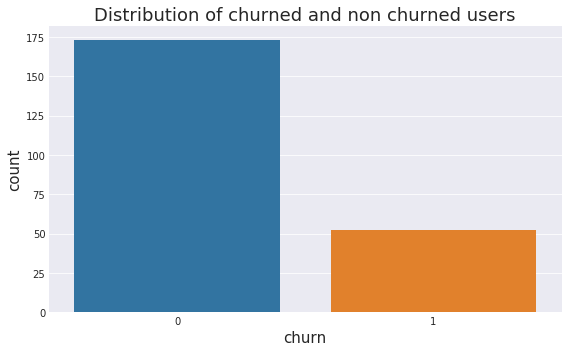

In [59]:
number_churn = df_clean.dropDuplicates(['userId']).groupby(['churn']).count()
number_churn.show()
number_churn_pd = number_churn.toPandas()


plot_sns_bar(x='churn',
             y='count', 
             data=number_churn_pd, 
             title='Distribution of churned and non churned users', 
             xlabel='churn', 
             ylabel='count', 
             save=True, 
             hide_xtick=False, 
             order=False)

#### Result:
- 23.11 % of all users churned

In [60]:
num_churn = 52
num_non_churn = 173

# <a class="anchor" id="Exploratory_Data_Analysis2">Exploratory Data Analysis Part 2</a>

## <a class="anchor" id="Gender_distribution_based_on_churn">Gender distribution based on churn</a>

In [61]:
def get_gender_distribution(df=df_clean):
    """ Get Gender distribution of users
        
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            gender_distribution - (Spark dataframe) with gender_count
        
    """
    gender_distribution = df.drop_duplicates(subset=['userId']).groupby('gender').count().withColumnRenamed('count', 'gender_count') 
    
    return gender_distribution

gender_distribution = get_gender_distribution()
gender_distribution.show()

+------+------------+
|gender|gender_count|
+------+------------+
|     F|         104|
|     M|         121|
+------+------------+



,gender,gender_count
0,F,104
1,M,121


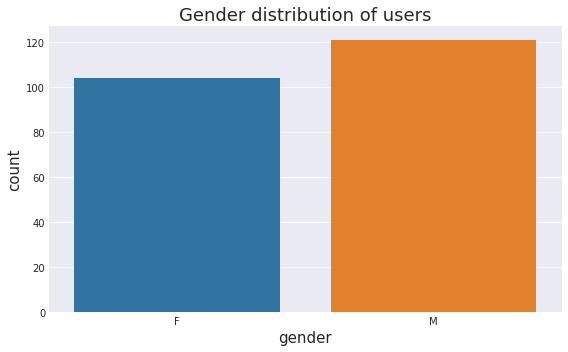

In [62]:
gender_distribution_pd = gender_distribution.toPandas()
display(gender_distribution_pd)
plot_sns_bar(x='gender',
             y='gender_count', 
             data=gender_distribution_pd, 
             title='Gender distribution of users', 
             xlabel='gender', 
             ylabel='count', 
             save=True, 
             hide_xtick=False, 
             order=False)

#### Result:
- 46.22% of all users are women
- 53.78% of all users are men

In [63]:
def get_gender_distribution_churn(df=df_clean):
    """ Get Gender distribution of churned and non churned users
        
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            gender_distribution_churn - (Spark dataframe) with gender distribution of churned and non churned users as percantage count
        
    """

    get_percentage_gender = udf(lambda x, y : x /121*100 if y=='M' else x /104*100)
    gender_distribution_churn = df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort('churn')
    #gender_distribution_churn.show()
    gender_distribution_churn = gender_distribution_churn.withColumn('count_percentage', get_percentage_gender(gender_distribution_churn['count'].cast(FloatType()), gender_distribution_churn['gender']))
    
    return gender_distribution_churn
  
gender_distribution_churn = get_gender_distribution_churn()
gender_distribution_churn.show()

+-----+------+-----+------------------+
|churn|gender|count|  count_percentage|
+-----+------+-----+------------------+
|    0|     M|   89| 73.55371900826447|
|    0|     F|   84| 80.76923076923077|
|    1|     F|   20|19.230769230769234|
|    1|     M|   32|26.446280991735538|
+-----+------+-----+------------------+



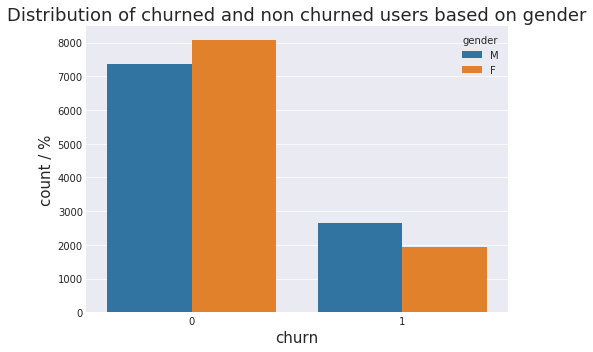

In [64]:
gender_distribution_churn_pd = gender_distribution_churn.toPandas()
gender_distribution_churn_pd['count_percentage'] = gender_distribution_churn_pd['count_percentage'].astype(float) *100
plot_sns_bar(x='churn',
             y='count_percentage', 
             data=gender_distribution_churn_pd, 
             hue='gender',
             title='Distribution of churned and non churned users based on gender', 
             xlabel='churn', 
             ylabel='count / %', 
             legend='gender',
             save=True, 
             hide_xtick=False, 
             order=False)

#### Result:
- There is no clear trend that women tend mor to churn 
- Gender seems not to be an important feature to predict churn

## <a class="anchor" id="member_dur">Membership duration</a>

In [65]:
# membership_duration
def get_membership_duration(df=df_clean):
    """ Get membership duration of users
        
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            membership_duration_churn - (Spark dataframe) including churn and a measure of membership duration for each user in days
            membership_duration - (Spark dataframe) including a measure of membership duration for each user in days
        
    """
    membership_duration= df.select('userId','registration','ts','churn')
    membership_duration = membership_duration.withColumn('membership_duration',(get_days(df.ts - df.registration)))
    membership_duration_churn = membership_duration.groupBy('userId','churn').agg({'membership_duration':'max'}).withColumnRenamed('max(membership_duration)', 'membership_duration')                                                    
    membership_duration = membership_duration.groupBy('userId').agg({'membership_duration':'max'}).withColumnRenamed('max(membership_duration)', 'membership_duration')                                                
    
    return membership_duration_churn, membership_duration

membership_duration_churn, membership_duration = get_membership_duration()
membership_duration.show()

+------+-------------------+
|userId|membership_duration|
+------+-------------------+
|100010|  55.64365740740741|
|200002|  70.07462962962963|
|   125|  71.31688657407408|
|   124|  99.99883101851852|
|    51|  9.997233796296296|
|     7|  72.77818287037037|
|    15|  9.859340277777777|
|    54|  99.99681712962963|
|   155|  9.097268518518518|
|100014|  85.08340277777778|
|   132|   66.8891087962963|
|   154| 7.1978587962962965|
|   101|         53.9659375|
|    11|  99.68056712962964|
|   138|  66.62668981481481|
|300017|  74.35851851851852|
|100021|  64.73886574074074|
|    29| 60.104050925925925|
|    69|  71.42444444444445|
|   112|  87.46262731481481|
+------+-------------------+
only showing top 20 rows



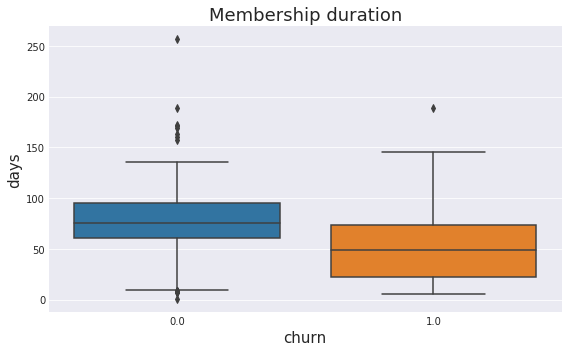

In [66]:
membership_duration_pd = membership_duration_churn.select('userId', 'churn', 'membership_duration').toPandas()
membership_duration_pd = membership_duration_pd.astype(np.float)
#display(membership_duration_pd)
plot_sns_box(x='churn', 
             y='membership_duration', 
             data=membership_duration_pd, 
             title='Membership duration', 
             xlabel='churn', 
             ylabel='days', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- User with a longer membership have a lower tendency to churn
- A useful feature to predict churn

## <a class="anchor" id="Total_page_activity_based_on_churn">Total page activity based on churn</a>

In [67]:
def get_total_page_activity_churn(df=df_clean):
    """ Get total page page activities of users
        
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            total_page_activity_churn - (Spark dataframe) with a persantage count of page activities for churned and non churned users
        
    """
    get_percentage_churn = udf(lambda x,y: x / num_churn * 100 if y==1 else x/ num_non_churn * 100)
    total_page_activity_churn = df.dropDuplicates(['userId', 'page']).groupby('page', 'churn').count()
    #total_page_activity_churn.show()
    total_page_activity_churn = total_page_activity_churn.withColumn('count_percentage', get_percentage_churn(total_page_activity_churn['count'].cast(FloatType()), total_page_activity_churn['churn']))

    return total_page_activity_churn

total_page_activity_churn = get_total_page_activity_churn()
total_page_activity_churn.show()

+---------------+-----+-----+------------------+
|           page|churn|count|  count_percentage|
+---------------+-----+-----+------------------+
|      Thumbs Up|    0|  170| 98.26589595375722|
|        Upgrade|    0|  131| 75.72254335260115|
|         Logout|    0|  167| 96.53179190751445|
|        Upgrade|    1|   37| 71.15384615384616|
|     Add Friend|    1|   44| 84.61538461538461|
|          Error|    1|   22| 42.30769230769231|
|           Home|    1|   51| 98.07692307692307|
|       NextSong|    0|  173|             100.0|
| Submit Upgrade|    0|  102| 58.95953757225434|
|           Help|    0|  149|  86.1271676300578|
|Add to Playlist|    1|   50| 96.15384615384616|
|  Save Settings|    0|  102| 58.95953757225434|
|  Save Settings|    1|   30|57.692307692307686|
|           Home|    0|  172| 99.42196531791907|
|Add to Playlist|    0|  165| 95.37572254335261|
|       Settings|    0|  152| 87.86127167630057|
|      Thumbs Up|    1|   50| 96.15384615384616|
|    Thumbs Down|   

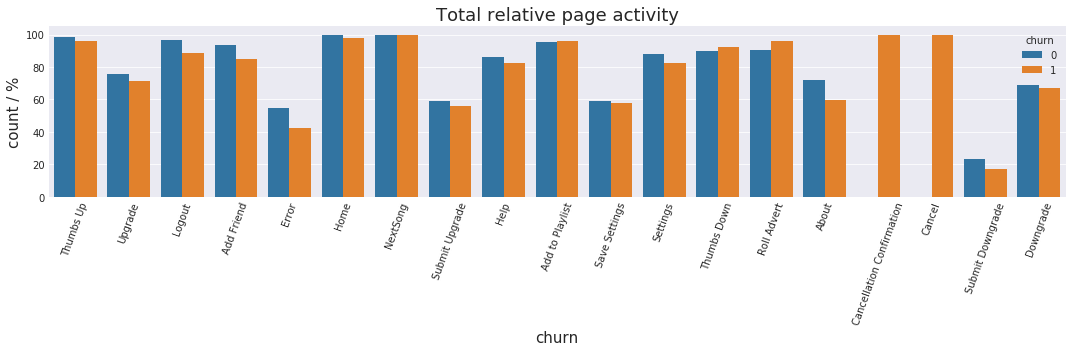

In [68]:
total_page_activity_churn_pd = total_page_activity_churn.toPandas()
total_page_activity_churn_pd['count_percentage'] = total_page_activity_churn_pd['count_percentage'].astype(float)
plot_sns_bar(x='page', 
             y='count_percentage', 
             hue='churn',
             data=total_page_activity_churn_pd, 
             title='Total relative page activity', 
             xlabel='churn', 
             ylabel='count / %', 
             legend='', 
             figsize=(15,5), 
             save=False, 
             hide_xtick=False, 
             rotation=70, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- The trends for some pages are not fully significant from this inspection
- However: It seems that the relative count of 'Add Friend', 'Thumbs Up' are interesting features wrt predicting churn. Thes relative count is here higher for non-churned users than for churned users.
- In contrast: 'Thumb Down' is higher for churned users than for non churned users. This feature could be also intersting for predicting churn.
- It could be, that in larger datasets those trends are more significant than in this small subset.

## <a class="anchor" id="total_number_of_songs_played_by_user">Total number of songs played by user</a>

In [69]:
def get_total_num_songs_played_user(df=df_clean):
    """ Get total total number of songs played by each user
        
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            total_num_songs_played_user_churn - (Spark dataframe) including churn and a total total number count of songs played by each user
            total_num_songs_played_user - (Spark dataframe) including a total total number count of songs played by each user
        
    """
    # mean Number of played songs per session 
    num_songs_played_user_session = df.select('userId', 'sessionId', 'churn').where(df.page=='NextSong').groupby('userId','sessionId', 'churn').count().sort('userId')
    #num_songs_played_user_session.show()
    total_num_songs_played_user_churn = num_songs_played_user_session.select('userId', 'churn','count').groupby('userId', 'churn').sum('count').sort(desc('sum(count)')).withColumnRenamed('sum(count)', 'total_num_songs_played') 
    total_num_songs_played_user = total_num_songs_played_user_churn.drop('churn')
    
    return total_num_songs_played_user_churn, total_num_songs_played_user

total_num_songs_played_user_churn, total_num_songs_played_user = get_total_num_songs_played_user()
total_num_songs_played_user.show()
printmd('#### Number of events: '+ str(total_num_songs_played_user.count()))

+------+----------------------+
|userId|total_num_songs_played|
+------+----------------------+
|    39|                  8002|
|    92|                  5945|
|   140|                  5664|
|300011|                  4619|
|   124|                  4079|
|300021|                  3816|
|300017|                  3632|
|    85|                  3616|
|    42|                  3573|
|     6|                  3159|
|    29|                  3028|
|200023|                  2955|
|    54|                  2841|
|   100|                  2682|
|     9|                  2676|
|    91|                  2580|
|   126|                  2577|
|300015|                  2524|
|    98|                  2401|
|    74|                  2400|
+------+----------------------+
only showing top 20 rows



#### Number of events: 225

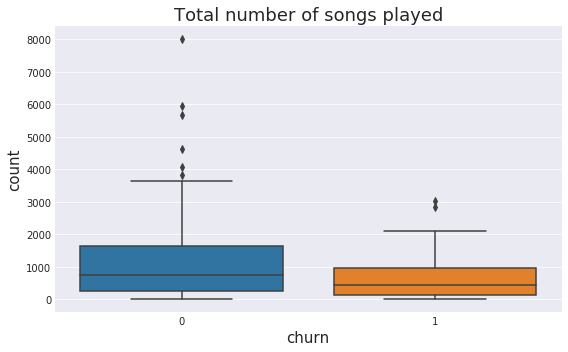

In [70]:
total_num_songs_played_user_pd = total_num_songs_played_user_churn.toPandas()
#display(total_num_songs_played_user_pd.iloc[:20])

plot_sns_box(x='churn', 
             y='total_num_songs_played', 
             data=total_num_songs_played_user_pd, 
             title='Total number of songs played', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- Non churned user play more songs than churned ones
- Non churned user seem to be more active on Sparkify, i.e. they seem to listen to songs on Sparkify more frequently
- num_songs_played_user_session seems to be a useful feature to predict churn

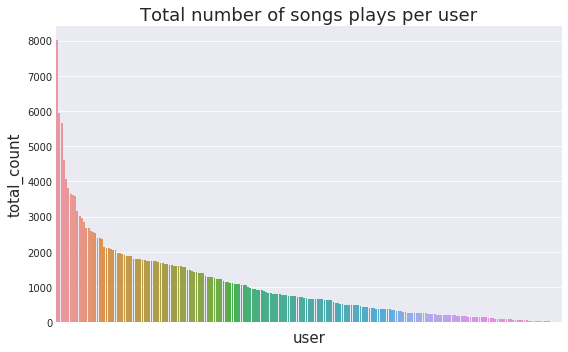

In [71]:
total_num_songs_played_user_pd = total_num_songs_played_user.toPandas()
#display(total_num_songs_played_user_pd)
plot_sns_bar(x='userId',
             y='total_num_songs_played', 
             data=total_num_songs_played_user_pd, 
             title='Total number of songs plays per user', 
             xlabel='user', 
             ylabel='total_count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='total_num_songs_played', 
             ascending=False)

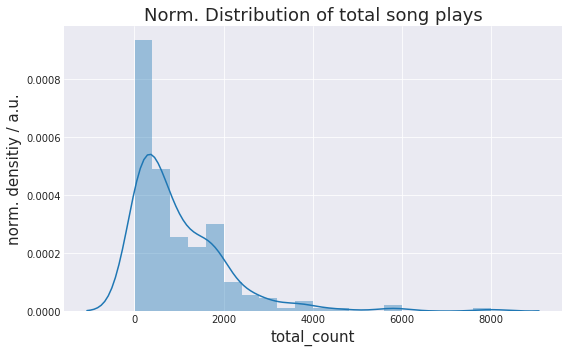

In [72]:
plot_sns_distplot(data=total_num_songs_played_user_pd, 
                  column_to_plot='total_num_songs_played', 
                  title='Norm. Distribution of total song plays', 
                  xlabel='total_count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="Average_number_of_songs_played_by_user_per_session">Average number of songs played per user per session</a>

In [73]:
def get_avg_num_songs_played_user_session(df=df_clean):
    """ Mean Number of played songs per session per user
        
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            avg_num_songs_played_user_session_churn - (Spark dataframe) including churn and avg number of songs played by each user per session
            avg_num_songs_played_user_session - (Spark dataframe) including avg number of songs played by each user per session
        
    """
    num_songs_played_user_session = df.select('userId', 'sessionId', 'churn').where(df.page=='NextSong').groupby('userId', 'sessionId', 'churn').count().sort('userId')
    #num_songs_played_user_session.show()
    avg_num_songs_played_user_session_churn = num_songs_played_user_session.select('userId', 'churn', 'count').groupby('userId', 'churn').mean('count').sort(desc('avg(count)')).withColumnRenamed('avg(count)', 'avg_num_songs_session') 
    avg_num_songs_played_user_session = avg_num_songs_played_user_session_churn.drop('churn')
    
    return avg_num_songs_played_user_session_churn, avg_num_songs_played_user_session

avg_num_songs_played_user_session_churn, avg_num_songs_played_user_session = get_avg_num_songs_played_user_session()
avg_num_songs_played_user_session.show()

printmd('#### Number of events: '+ str(avg_num_songs_played_user_session.count()))

+------+---------------------+
|userId|avg_num_songs_session|
+------+---------------------+
|    91|    286.6666666666667|
|    19|                216.0|
|    51|                211.1|
|    62|              198.875|
|   101|                179.7|
|   115|                173.7|
|    23|                164.0|
|    41|   157.83333333333334|
|   105|                152.8|
|    77|   149.57142857142858|
|   124|   145.67857142857142|
|     6|    143.5909090909091|
|    44|                143.0|
|    58|   141.16666666666666|
|   138|                138.0|
|   151|                138.0|
|    15|   136.71428571428572|
|   155|   136.66666666666666|
|    89|                133.4|
|    17|   132.42857142857142|
+------+---------------------+
only showing top 20 rows



#### Number of events: 225

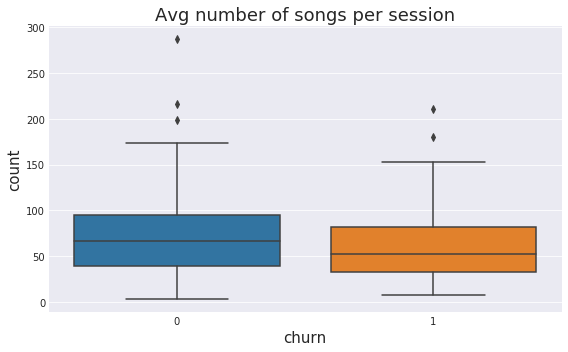

In [74]:
avg_num_songs_played_user_session_pd = avg_num_songs_played_user_session_churn.toPandas()
#display(avg_num_songs_played_user_session_pd

plot_sns_box(x='churn', 
             y='avg_num_songs_session', 
             data=avg_num_songs_played_user_session_pd, 
             title='Avg number of songs per session', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- Non churned user play more songs per session than churned ones
- Non churned user seem to be more active, they seem to listen to songs on Sparkify more frequently
- avg_num_songs_played_user_session seems to be a useful feature to predict churn

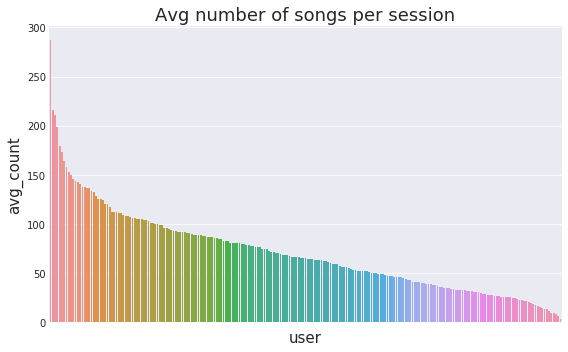

In [75]:
#display(avg_num_songs_playes_user_session_pd)
plot_sns_bar(x='userId',
             y='avg_num_songs_session', 
             data=avg_num_songs_played_user_session_pd, 
             title='Avg number of songs per session', 
             xlabel='user', 
             ylabel='avg_count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='avg_num_songs_session', 
             ascending=False)

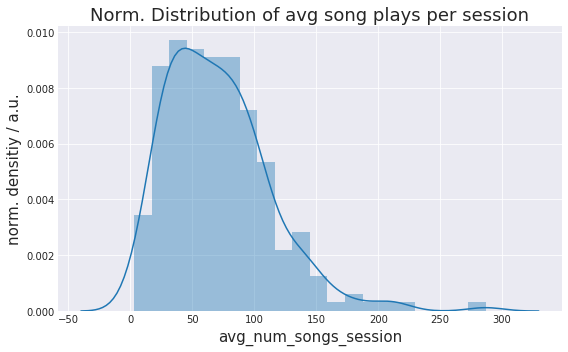

In [76]:
plot_sns_distplot(data=avg_num_songs_played_user_session_pd, 
                  column_to_plot='avg_num_songs_session', 
                  title='Norm. Distribution of avg song plays per session', 
                  xlabel='avg_num_songs_session', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="total_number_of_thumbs_up_per_user">Total number of thumbs up per user</a>

In [77]:
def get_thumbs_up(df=df_clean):
    """ Number of thumbs up events for each user
    
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            thumbs_up_churn - (Spark dataframe) including churn and a count of thumbs up events for each user
            thumbs_up - (Spark dataframe) including a count of thumbs up events for each user
        
    """

    thumbs_up_churn = df.select('userId', 'churn').where(df.page=='Thumbs Up').groupby('userId', 'churn').count().sort(desc('count')).withColumnRenamed('count', 'num_thumbs_up') 
    thumbs_up = thumbs_up_churn.drop('churn')
    
    return thumbs_up_churn, thumbs_up

thumbs_up_churn, thumbs_up = get_thumbs_up()
thumbs_up.show()

printmd('#### Number of events: '+ str(thumbs_up.count()))

+------+-------------+
|userId|num_thumbs_up|
+------+-------------+
|300011|          437|
|    39|          388|
|300021|          336|
|300017|          303|
|    92|          292|
|   140|          277|
|300015|          193|
|    85|          192|
|   124|          171|
|300023|          169|
|    42|          166|
|     6|          165|
|    54|          163|
|200023|          163|
|    29|          154|
|   100|          148|
|300001|          148|
|300002|          140|
|300025|          139|
|   126|          135|
+------+-------------+
only showing top 20 rows



#### Number of events: 220

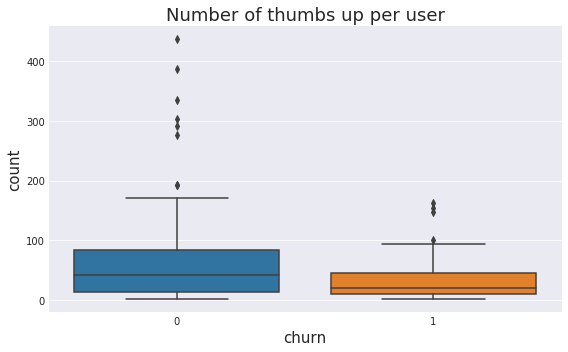

In [78]:
thumbs_up_pd = thumbs_up_churn.toPandas()
#display(thumbs_up)

plot_sns_box(x='churn', 
             y='num_thumbs_up', 
             data=thumbs_up_pd, 
             title='Number of thumbs up per user', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- There are more 'thumbs up' for non churned user than for churned ones
- thumbs_up seems to be a useful feature to predict churn

In [79]:
"""
thumbs_up = spark.sql('''
                      SELECT userId, count(*) as num_thumbs_up
                      FROM sparkify_sql_view 
                      where page = 'Thumbs Up' 
                      group by userId
                      ''')

thumbs_up.show()
"""

"\nthumbs_up = spark.sql('''\n                      SELECT userId, count(*) as num_thumbs_up\n                      FROM sparkify_sql_view \n                      where page = 'Thumbs Up' \n                      group by userId\n                      ''')\n\nthumbs_up.show()\n"

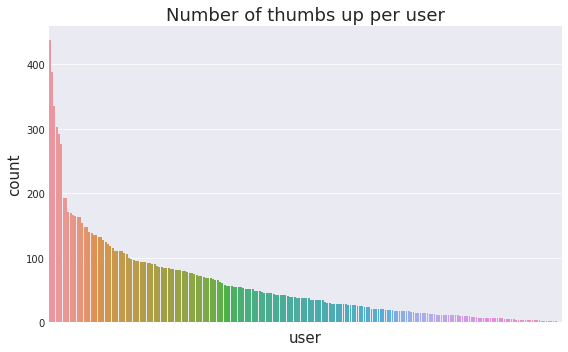

In [80]:
#display(thumbs_up_pd)

plot_sns_bar(x='userId',
             y='num_thumbs_up', 
             data=thumbs_up_pd, 
             title='Number of thumbs up per user', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='num_thumbs_up', 
             ascending=False)

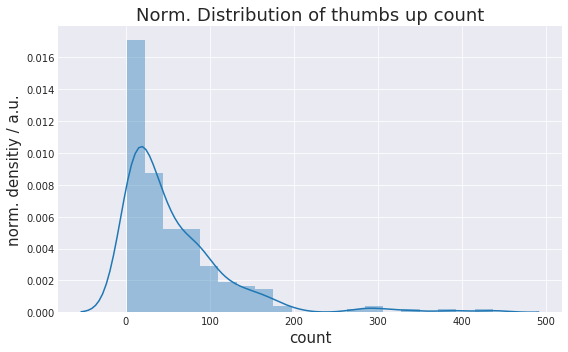

In [81]:
plot_sns_distplot(data=thumbs_up_pd, 
                  column_to_plot='num_thumbs_up', 
                  title='Norm. Distribution of thumbs up count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="total_number_of_thumbs_down_per_user">Total number of thumbs down per user</a>

In [82]:
def get_thumbs_down(df=df_clean):
    """ Number of thumbs up events for each user
    
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            thumbs_down_churn - (Spark dataframe) including churn and a count of thumbs down events for each user
            thumbs_down - (Spark dataframe) including a count of thumbs down events for each user
        
    """
    thumbs_down_churn = df.select('userId', 'churn').where(df.page=='Thumbs Down').groupby('userId', 'churn').count().sort(desc('count')).withColumnRenamed('count', 'num_thumbs_down')
    thumbs_down = thumbs_down_churn.drop('churn')
    
    return thumbs_down_churn, thumbs_down

thumbs_down_churn, thumbs_down = get_thumbs_down()    
thumbs_down.show()

printmd('#### Number of events: '+ str(thumbs_down.count()))

+------+---------------+
|userId|num_thumbs_down|
+------+---------------+
|   140|             75|
|200023|             73|
|    92|             72|
|    39|             69|
|200004|             54|
|200008|             52|
|300011|             41|
|   124|             41|
|    85|             38|
|200020|             36|
|300021|             36|
|200021|             35|
|     9|             32|
|200009|             32|
|     6|             31|
|    54|             29|
|300017|             28|
|200014|             28|
|   118|             27|
|200025|             27|
+------+---------------+
only showing top 20 rows



#### Number of events: 203

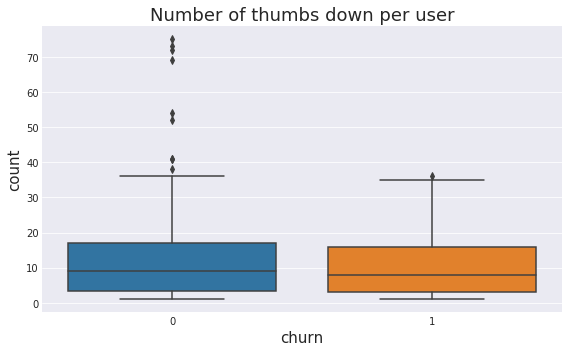

In [83]:
thumbs_down_pd = thumbs_down_churn.toPandas()
#display(thumbs_down)

plot_sns_box(x='churn', 
             y='num_thumbs_down', 
             data=thumbs_down_pd, 
             title='Number of thumbs down per user', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- There are also slightly more 'thumbs down' for non churned user than for churned ones
- The trend of thumbs_down as a useful feature to predict churn is not clear at the moment

In [84]:
"""
# SQL view 
df.createOrReplaceTempView("sparkify_sql_view")
thumbs_down = spark.sql('''
                        SELECT userId, count(*) as num_thumbs_down 
                        FROM sparkify_sql_view 
                        where page = 'Thumbs Down' 
                        group by userId
                        ''')

thumbs_down.show()
"""

'\n# SQL view \ndf.createOrReplaceTempView("sparkify_sql_view")\nthumbs_down = spark.sql(\'\'\'\n                        SELECT userId, count(*) as num_thumbs_down \n                        FROM sparkify_sql_view \n                        where page = \'Thumbs Down\' \n                        group by userId\n                        \'\'\')\n\nthumbs_down.show()\n'

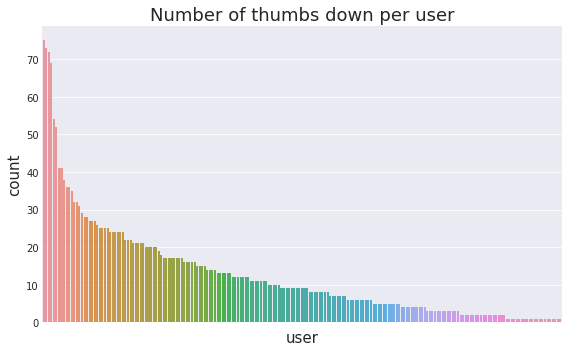

In [85]:
plot_sns_bar(x='userId',
             y='num_thumbs_down', 
             data=thumbs_down_pd, 
             title='Number of thumbs down per user', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='num_thumbs_down', 
             ascending=False)

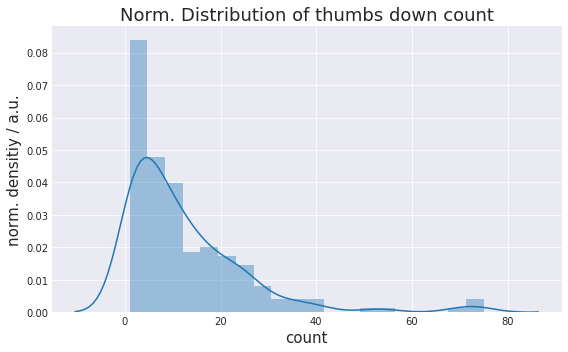

In [86]:
plot_sns_distplot(data=thumbs_down_pd, 
                  column_to_plot='num_thumbs_down', 
                  title='Norm. Distribution of thumbs down count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="Total_number_of_errors_per_user">Total number of errors per user</a>

In [87]:
def get_error(df=df_clean):
    """ Number of error events for each user
    
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            error_churn - (Spark dataframe) including churn and count of error events for each user
            error - (Spark dataframe) including count of error events for each user
        
    """
    error_churn = df.select('userId', 'churn').where(df.page=='Error').groupby('userId', 'churn').count().sort(desc('count')).withColumnRenamed('count', 'num_errors')
    error = error_churn.drop('churn')
    
    return error_churn, error

error_churn, error = get_error()   
error.show()

printmd('#### Number of events: '+ str(error.count()))

+------+----------+
|userId|num_errors|
+------+----------+
|    39|         7|
|    42|         7|
|   140|         7|
|   124|         6|
|   142|         5|
|300017|         5|
|    95|         5|
|300021|         5|
|     4|         4|
|   131|         4|
|    49|         4|
|     6|         4|
|300015|         4|
|    69|         4|
|    59|         4|
|    62|         4|
|300023|         3|
|   100|         3|
|   155|         3|
|300008|         3|
+------+----------+
only showing top 20 rows



#### Number of events: 117

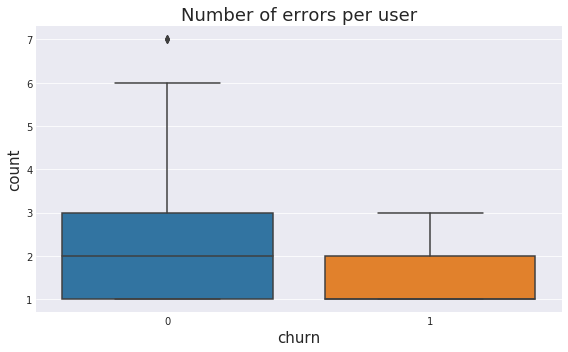

In [88]:
error_pd = error_churn.toPandas()

plot_sns_box(x='churn', 
             y='num_errors', 
             data=error_pd, 
             title='Number of errors per user', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- The error trend does not seem to influence churn dramatically.
- It seems that errors are forgiven. 
- Maybe the reason for that could be, that the amount of errors is small. Median < 2.
- A there is no significant trend this feature will not be chosen to predict churn

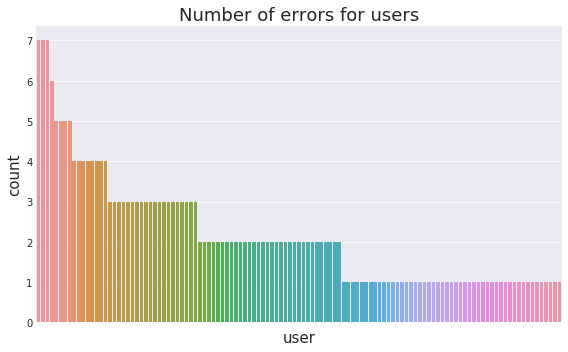

In [89]:
#display(thumbs_up_pd)

plot_sns_bar(x='userId',
             y='num_errors', 
             data=error_pd, 
             title='Number of errors for users', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='num_errors', 
             ascending=False)

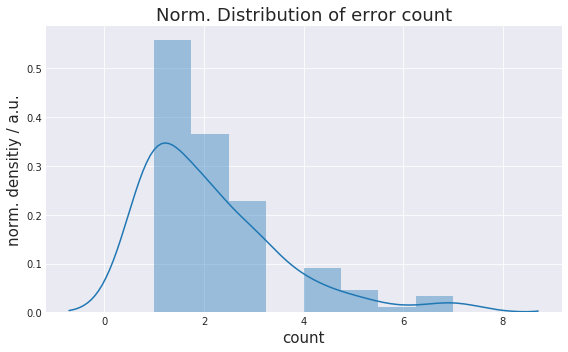

In [90]:
plot_sns_distplot(data=error_pd, 
                  column_to_plot='num_errors', 
                  title='Norm. Distribution of error count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=8, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="Total_number_of_Add_to_playlist_clicks_per_user">Total number of "Add to playlist" clicks per user</a>

In [91]:
def get_add_to_playlist(df=df_clean):
    """ Number of add_to_playlist events for each user
    
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            add_to_playlist_churn - (Spark dataframe) including churn and count of add_to_playlist events for each user
            add_to_playlist - (Spark dataframe) including count of add_to_playlist events for each user
        
    """
    add_to_playlist_churn = df.select('userId', 'churn').where(df.page=='Add to Playlist').groupby('userId', 'churn').count().sort(desc('count')).withColumnRenamed('count', 'num_add_playlist')
    add_to_playlist = add_to_playlist_churn.drop('churn')
    
    return add_to_playlist_churn, add_to_playlist

add_to_playlist_churn, add_to_playlist = get_add_to_playlist()
add_to_playlist.show()

printmd('#### Number of events: '+ str(add_to_playlist.count()))

+------+----------------+
|userId|num_add_playlist|
+------+----------------+
|    39|             240|
|    92|             181|
|   140|             148|
|300011|             146|
|   124|             118|
|300017|             113|
|    85|             108|
|300021|             107|
|    42|             104|
|    29|              89|
|     6|              83|
|    74|              80|
|     9|              77|
|200023|              73|
|   126|              72|
|    54|              72|
|300001|              69|
|    65|              68|
|200004|              67|
|   138|              67|
+------+----------------+
only showing top 20 rows



#### Number of events: 215

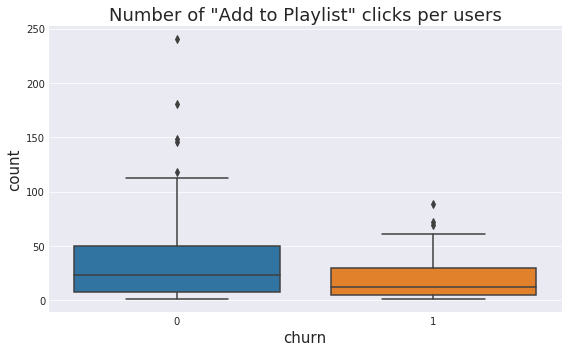

In [92]:
add_to_playlist_pd = add_to_playlist_churn.toPandas()

plot_sns_box(x='churn', 
             y='num_add_playlist', 
             data=add_to_playlist_pd, 
             title='Number of "Add to Playlist" clicks per users', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- There are more 'Add to Playlist' events for non churned user than for churned ones
- add_to_playlist seems to be a useful feature to predict churn

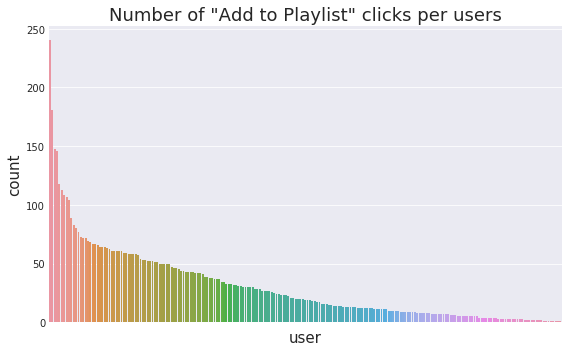

In [93]:
plot_sns_bar(x='userId',
             y='num_add_playlist', 
             data=add_to_playlist_pd, 
             title='Number of "Add to Playlist" clicks per users', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='num_add_playlist', 
             ascending=False)

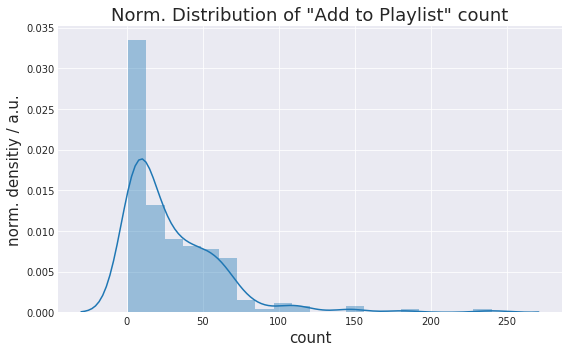

In [94]:
plot_sns_distplot(data=add_to_playlist_pd, 
                  column_to_plot='num_add_playlist', 
                  title='Norm. Distribution of "Add to Playlist" count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="Total_number_of_Add_Friend_clicks_per_user">Total number of "Add Friend" clicks per user</a>

In [95]:
def get_add_friend(df=df_clean):
    """ Number of add_friend events for each user
    
        INPUTS:
        ------------
            df - (Spark dataframe) the cleaned Dataframe used for modeling
        
        OUTPUTS:
        ------------
            add_friend - (Spark dataframe) with count of add_friend events for each user
        
    """
    add_friend_churn = df.select('userId', 'churn').where(df.page=='Add Friend').groupby('userId', 'churn').count().sort(desc('count')).withColumnRenamed('count', 'num_add_friends')
    add_friend = add_friend_churn.drop('churn')
    
    return add_friend_churn, add_friend

add_friend_churn, add_friend = get_add_friend()
add_friend.show()

printmd('#### Number of events: '+ str(add_friend.count()))

+------+---------------+
|userId|num_add_friends|
+------+---------------+
|   140|            143|
|    39|            122|
|    92|            110|
|300011|             93|
|300021|             89|
|   124|             74|
|200023|             66|
|300017|             63|
|   136|             60|
|    85|             58|
|    65|             53|
|   118|             52|
|    42|             52|
|   100|             49|
|    29|             47|
|300015|             47|
|     4|             46|
|    98|             45|
|    74|             43|
|    91|             42|
+------+---------------+
only showing top 20 rows



#### Number of events: 206

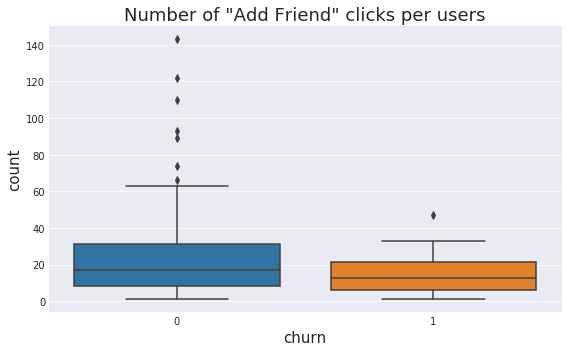

In [96]:
add_friend_pd = add_friend_churn.toPandas()

plot_sns_box(x='churn', 
             y='num_add_friends', 
             data=add_friend_pd, 
             title='Number of "Add Friend" clicks per users', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- There are more 'Add Friend' events for non churned user than for churned ones
- add_friend seems to be a useful feature to predict churn

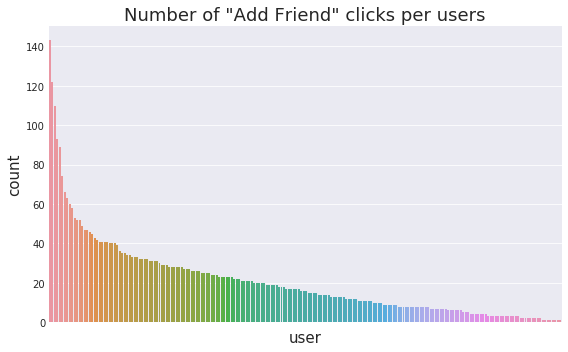

In [97]:
#display(add_friend_pd)

plot_sns_bar(x='userId',
             y='num_add_friends', 
             data=add_friend_pd, 
             title='Number of "Add Friend" clicks per users', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='num_add_friends', 
             ascending=False)

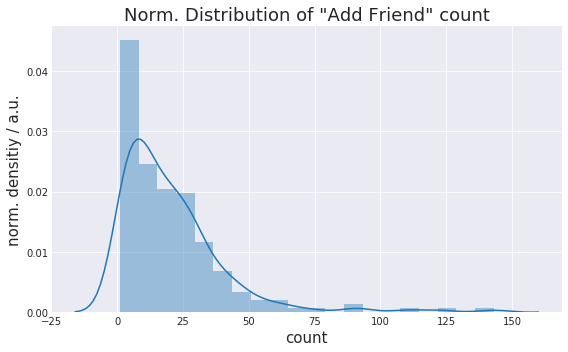

In [98]:
plot_sns_distplot(data=add_friend_pd, 
                  column_to_plot='num_add_friends', 
                  title='Norm. Distribution of "Add Friend" count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="feature_report">Feature report</a>

In [99]:
def get_feature_report(df, df_var_name, column_name, cast_type='int'):
    feature_dict = {}
    if cast_type == 'int':
        min_val = df.agg(min(column_name).cast(FloatType())).collect()[0][0]
        max_val = df.agg(max(column_name).cast(FloatType())).collect()[0][0]
        count_val = df.count()
        feature_dict[df_var_name] = (min_val, max_val, count_val)
    
    if cast_type == 'float':
        min_val = df.agg(min(column_name).cast(IntegerType())).collect()[0][0]
        max_val = df.agg(max(column_name).cast(IntegerType())).collect()[0][0]
        count_val = df.count()
        feature_dict[df_var_name] = (min_val, max_val, count_val)
    
    return feature_dict


membership_duration, _= get_membership_duration(df_clean)
total_num_songs_played_user, _ = get_total_num_songs_played_user(df_clean)
avg_num_songs_played_user_session, _ = get_avg_num_songs_played_user_session(df_clean)
thumbs_up, _ = get_thumbs_up(df_clean)
thumbs_down, _ = get_thumbs_down()
add_to_playlist, _ = get_add_to_playlist(df_clean)
add_friend, _ = get_add_friend(df_clean)
    

feature_report_list = [(membership_duration, 'membership_duration', 'membership_duration', 'float'),
                        (total_num_songs_played_user, 'total_num_songs_played', 'total_num_songs_played', 'int'),
                        (avg_num_songs_played_user_session, 'avg_num_songs_played_user_session', 'avg_num_songs_session', 'int'),
                        (thumbs_up, 'thumbs_up', 'num_thumbs_up', 'int'),
                        (thumbs_down, 'thumbs_down', 'num_thumbs_down', 'int'),
                        (add_to_playlist, 'add_to_playlist', 'num_add_playlist', 'int'),
                        (add_friend, 'add_friend', 'num_add_friends', 'int')]


feature_description = {}
for df, df_var_name, column_name, cast_type in feature_report_list:
    feature_description.update(get_feature_report(df, df_var_name, column_name, cast_type))
feature_description

{'membership_duration': (0, 99, 225),
 'total_num_songs_played': (3.0, 8002.0, 225),
 'avg_num_songs_played_user_session': (3.0, 286.6666564941406, 225),
 'thumbs_up': (1.0, 437.0, 220),
 'thumbs_down': (1.0, 75.0, 203),
 'add_to_playlist': (1.0, 240.0, 215),
 'add_friend': (1.0, 143.0, 206)}

In [100]:
pd.DataFrame(feature_description , index=['min', 'max', 'count']).T

,min,max,count
membership_duration,0.0,99.000000,225.0
total_num_songs_played,3.0,8002.000000,225.0
avg_num_songs_played_user_session,3.0,286.666656,225.0
thumbs_up,1.0,437.000000,220.0
thumbs_down,1.0,75.000000,203.0
add_to_playlist,1.0,240.000000,215.0
add_friend,1.0,143.000000,206.0


# <a class="anchor" id="Feature_Engineering">Feature Engineering</a>
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Result:
- features need to be scaled for modeling due to the spread of min/max values
- some features have nan values at the moment. Those NaNs must be handled as 0

In [101]:
def create_dataframe_for_modeling(path_to_df="mini_sparkify_event_data.json"):
    """ This function will create labels and features for modeling
        - Read the dataframe from a json file
        - Clean the Dataframe
        - Define churn, create a label column
        - Create feature columns
        - Remove unnecassary columns
        - Fill NaN with 0
        - Cast features to float
        - Rename churn with label
        - Return model dataframe
    
        INPUTS:
        ------------
            path_to_df - (string) the path to the csv file containing the data
            
        OUTPUTS:
        ------------
            df_model - (Spark dataframe) this is the DataFrame used to predict churn 
         
    """
    
    # Create a Spark session
    spark = SparkSession \
        .builder \
        .appName("Wrangling Data") \
        .getOrCreate()
    
    """
    Read the dataframe
    """
    df = spark.read.json(path_to_df)
    
    
    """
    Clean the dataframe 
    """
    df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df_clean = df_clean.filter(df_clean["userId"] != "")
    
    """
    Define churn, create label column
    """
    # Create a churn column - get churn for each user --> churn=1 (user churned), churn=0 (user not churned) 
    flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df_clean = df_clean.withColumn('churn_event', flag_churn_event('page'))
    df_clean = df_clean.withColumn('churn', max('churn_event').over(Window.partitionBy('userId')))
    
    # The label baseline dataframe for modeling 
    churn = df_clean.select(['userId','churn']).dropDuplicates(['userId'])
    df_churn = churn.withColumn('churn', churn.churn.cast('int'))
    
    
    """
    Create feature columns
    """
    # Join features
    _, membership_duration = get_membership_duration(df_clean)
    _, total_num_songs_played_user = get_total_num_songs_played_user(df_clean)
    _, avg_num_songs_played_user_session = get_avg_num_songs_played_user_session(df_clean)
    _, thumbs_up = get_thumbs_up(df_clean)
    _, thumbs_down = get_thumbs_down()
    _, add_to_playlist = get_add_to_playlist(df_clean)
    _, add_friend = get_add_friend(df_clean)
    
    feature_list = [membership_duration,
                    total_num_songs_played_user, 
                    avg_num_songs_played_user_session, 
                    thumbs_up,
                    thumbs_down, 
                    add_to_playlist, 
                    add_friend
                    ]
    
    
    # generate the data set for the model 
    df_model = df_churn
    df_model.persist()

    for i, features in enumerate(feature_list):
        df_model = df_model.join(features,'userId','outer')
        
        
    """
    Remove unnecassary columns
    """
    # drop userID
    df_model = df_model.drop('userId') 
    
    
    """
    Fill NaN with 0
    """
    df_model = df_model.fillna(0)
    
    cols = ['membership_duration', 
            'total_num_songs_played', 
            'avg_num_songs_session', 
            'num_thumbs_up', 
            'num_thumbs_down', 
            'num_add_playlist', 
            'num_add_friends']
   
    """
    Cast features to float
    """
    for col_name in cols:
        df_model = df_model.withColumn(col_name, col(col_name).cast('float'))
        
        
    """
    Rename churn with label
    """
    df_model = df_model.withColumnRenamed("churn","label")
    
    

    return df_model
    
df_model = create_dataframe_for_modeling()

In [102]:
df_model.printSchema()

root
 |-- label: integer (nullable = true)
 |-- membership_duration: float (nullable = true)
 |-- total_num_songs_played: float (nullable = true)
 |-- avg_num_songs_session: float (nullable = false)
 |-- num_thumbs_up: float (nullable = true)
 |-- num_thumbs_down: float (nullable = true)
 |-- num_add_playlist: float (nullable = true)
 |-- num_add_friends: float (nullable = true)




# <a class="anchor" id="modeling">Modeling</a>
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## <a class="anchor" id="modeling">Prepare model dataframe</a>

In [103]:
def prepare_model_dataframe(df_model, scaler='minmax'):
    """ Prepare df_model for model creation
        - Numeric columns will be converted to Spark's vector type via VectorAssembler
        - A scaler object will be created
        - Data will be split into training and validation data
        
        INPUTS:
        ------------
            df_model - (Spark dataframe) this is the DataFrame used to predict churn 
            scaler - (string) identifier to choose between different scaling methods
            
        OUTPUTS:
        ------------
            df_model - (Spark dataframe) this is the DataFrame used to predict churn 
            training_data - (Spark dataframe) containing the subset with training data
            validation_data - (Spark dataframe) containing the subset with validation data
            scaler - (Spark scaler object) a scaling object used for the ML pipeline in build_model()       
    """
    """
    Create a VectorAssembler
    """
    # Numeric columns must be converted to Spark's vector type
    assembler = VectorAssembler(inputCols=df_model.columns[1:], outputCol="features")
    #df_model = assembler.transform(df_model)
    #df_model.head()

    """
    Scale the input features
    """
    if scaler == 'standard':
        scaler = StandardScaler(inputCol="features", outputCol="ScaledNumFeatures",  withStd=True, withMean=False)
        #scalerModel = scaler.fit(df_model)
        #df_model = scalerModel.transform(df_model)
        #df_model.head()

    elif scaler == 'minmax':
        scaler = MinMaxScaler(inputCol="features", outputCol="ScaledNumFeatures")
        #scalerModel = scaler.fit(df_model)
        #df_model = scalerModel.transform(df_model)
        #df_model.head()

    elif scaler == 'norm':
        scaler = Normalizer(inputCol="features", outputCol="ScaledNumFeatures")
        #scalerModel = scaler.fit(df_model)
        #df_model = scalerModel.transform(df_model)
        #df_model.head()


    """
    Split the data into train and test 
    """
    training_data, validation_data = df_model.randomSplit([0.9, 0.1], seed=42)
    
    return df_model, training_data, validation_data, scaler, assembler
    
df_model, training_data, validation_data, scaler, assembler = prepare_model_dataframe(df_model)

In [104]:
df_model.printSchema()

root
 |-- label: integer (nullable = true)
 |-- membership_duration: float (nullable = true)
 |-- total_num_songs_played: float (nullable = true)
 |-- avg_num_songs_session: float (nullable = false)
 |-- num_thumbs_up: float (nullable = true)
 |-- num_thumbs_down: float (nullable = true)
 |-- num_add_playlist: float (nullable = true)
 |-- num_add_friends: float (nullable = true)



In [105]:
df_model.head()

Row(label=0, membership_duration=55.64365768432617, total_num_songs_played=275.0, avg_num_songs_session=39.28571319580078, num_thumbs_up=17.0, num_thumbs_down=5.0, num_add_playlist=7.0, num_add_friends=4.0)

In [106]:
printmd('#### df_model shape')
print((df_model.count(), len(df_model.columns)))

#### df_model shape

(225, 8)


In [107]:
printmd('#### training_data shape')
print((training_data.count(), len(training_data.columns)))

#### training_data shape

(209, 8)


In [108]:
printmd('#### validation_data shape')
print((validation_data.count(), len(validation_data.columns)))

#### validation_data shape

(16, 8)


In [ ]:
numeric_features = [t[0] for t in df_model.dtypes if t[1] == 'float']
df.select(numeric_features).describe().toPandas().transpose()

## <a class="anchor" id="build_model">Build a Model</a>

In [149]:
def build_model(training_data, validation_data, classifier):
    """ Create models
        - Random Forest
        - Logistic Regression
        - radient Boosting Tree Classifier 
        
        
        INPUTS:
        ------------
            training_data - (Spark dataframe) containing the subset with training data
            validation_data - (Spark dataframe) containing the subset with validation data
            classifier - (string) identifier to choose a classifier      
        
        OUTPUTS:
        ------------
            cvModel - (CrossValidator model object) it contains all modelling data
            results - (Spark dataframe) with model results
    """
    # Random Forest
    if classifier == 'rf':
        rf = RandomForestClassifier(labelCol="label", featuresCol="ScaledNumFeatures", numTrees=10)
        pipeline = Pipeline(stages=[assembler, scaler, rf])
        paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees,[5, 8, 10]) \
            .build()
    
    # Logistic Regression   
    if classifier == 'lr':
        lr = LogisticRegression(labelCol="label", featuresCol="ScaledNumFeatures", maxIter=10, regParam=0.0, elasticNetParam=0)
        pipeline = Pipeline(stages=[assembler, scaler, lr])
        paramGrid = ParamGridBuilder() \
            .addGrid(lr.maxIter,[5, 8, 10]) \
            .build()
        
    # Gradient Boosting Tree Classifier    
    if classifier == 'gbt':
        gbt = GBTClassifier(labelCol="label", featuresCol="ScaledNumFeatures", maxIter=10)
        pipeline = Pipeline(stages=[assembler, scaler, gbt])
        paramGrid = ParamGridBuilder() \
            .addGrid(gbt.maxIter,[5, 8, 10]) \
            .build()
    
    # Crossvalidation     
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3,
                          collectSubModels=True)

    cvModel = crossval.fit(training_data)
    results = cvModel.bestModel.transform(validation_data)
    
    return cvModel, results


def evalualte_model(cvModel, results):
    """ Evaluate models
        - Random Forest
        - Logistic Regression
        - radient Boosting Tree Classifier 
        
        INPUTS:
        ------------
            cvModel - (CrossValidator model object) it contains all modelling data
            results - (Spark dataframe) with model results
        
        OUTPUTS:
        ------------
            df_f1 - (pandas DataFrame) containing metrics parameters from cvModel
            df_feature_importance - (pandas DataFrame) containing most important coefficints (regression) or weights (classification) 
            accuracy - (float) - accuracy of the model
            precision - (float) - precision of the model
            recall - (float) - recall of the model
            f1 - (float) - f1 of the model
    """
    
    # Get metric from cvModel: dafault --> f1 score
    params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]
    
    df_f1 = pd.DataFrame.from_dict([
                {cvModel.getEvaluator().getMetricName(): metric, **ps} 
                for ps, metric in zip(params, cvModel.avgMetrics)
                ])
    
    
    # Get Feature Importance Map
    try:
        feature_coefficients = cvModel.bestModel.stages[2].coefficients.values.tolist()
    except:
        feature_coefficients = cvModel.bestModel.stages[2].featureImportances.values.tolist()
        
    df_feature_importance = pd.DataFrame(list(zip(df_model.columns[1:], feature_coefficients)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)
    
    
    return df_f1, df_feature_importance

## <a class="anchor" id="rf">RandomForestClassifier</a>

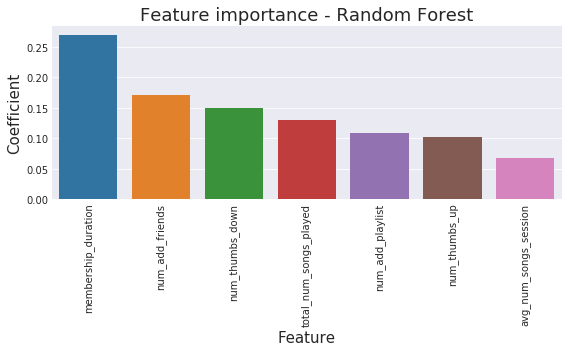

In [145]:
cvModel_rf, results_rf = build_model(training_data, validation_data, 'rf')
df_f1_rf, df_feature_importance_rf = evalualte_model(cvModel_rf, results_rf)
plot_sns_bar(x='Feature',
             y='Coefficient', 
             data=df_feature_importance_rf, 
             title='Feature importance - Random Forest', 
             xlabel='Feature', 
             ylabel='Coefficient', 
             save=True, 
             hide_xtick=False,
             rotation=90,
             order=False)

In [146]:
printmd('#### Metrics - Random Forest Model')
display(df_f1_rf)

f1_rf = df_f1_rf['f1'].max()
numTrees_rf = df_f1_rf['numTrees'][df_f1_rf['f1']==f1_rf].values[0]
print('Best model f1 score: ', f1_rf)
print('Best model num_trees: ', numTrees_rf)

#### Metrics - Random Forest Model

,f1,numTrees
0,0.717408,5
1,0.729987,8
2,0.753723,10


Best model f1 score:  0.753722894803
Best model num_trees:  10


### Result:
- f1 score at 75%
- It seems that an increase of num_trees enhances prediction result. However, an increase of num_trees increases prediction time and memory usage.
- The tree most important features to predict **churn** are:
    - membership_duration
    - num_thumbs_down
    - num_thumbs_up
   

#### Most important tuning parameters for Random Forest:
- **numTrees** – Number of trees in the forest. This parameter is usually the most important setting
- **maxDepth** – Max number of levels in each decision tree

#### Some other parameters to consider testing:
- **featureSubsetStrategy** – Number of features to use as candidates for splitting at each tree node
- **minInfoGain** – Minimum information gain for a split to be considered at a tree node
- **minInstancesPerNode** – Minimum number of instances each child must have after split

### Further optimizations:
- Increase numTrees further (e.g. 20...50) 
- Tune maxDepth. An increase of maxDepth could help to increase f1 score.
- Use a larger dataset. 225 unique users is just a small subset.
- Implement further features for modeling

## <a class="anchor" id="lr">LogisticRegression</a>
As we do have a binary label set we could try a binary logistic regression approach to predict churn

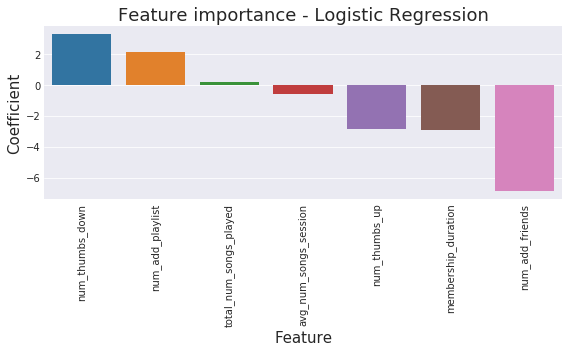

In [150]:
cvModel_lr, results_lr = build_model(training_data, validation_data, 'lr')
df_f1_lr, df_feature_importance_lr = evalualte_model(cvModel_lr, results_lr)
plot_sns_bar(x='Feature',
             y='Coefficient', 
             data=df_feature_importance_lr, 
             title='Feature importance - Logistic Regression', 
             xlabel='Feature', 
             ylabel='Coefficient', 
             save=True, 
             hide_xtick=False,
             rotation=90,
             order=False)

In [152]:
printmd('#### Metrics - Logistic Regression Model')
display(df_f1_lr)

f1_lr = df_f1_lr['f1'].max()
maxIter_lr = df_f1_lr['maxIter'][df_f1_lr['f1']==f1_lr].values[0]
print('Best model f1 score: ', f1_lr)
print('Best model regParam: ', maxIter_lr)

#### Metrics - Logistic Regression Model

,f1,maxIter
0,0.693433,5
1,0.702545,8
2,0.706435,10


Best model f1 score:  0.706434922265
Best model regParam:  10


### Result:
- f1 score at 71%
- It seems that an increase of iterations (maxIter) enhances f1 score. However, overfitting issues arises for the dafault value maxIter=100 (not shown).
- The most important features to predict **churn** are:
    - num_add_friends
    - membership_duration
    - num_thumbs_down
    - num_thumbs_up
- Except for num_add_friends a similar feature importance has been observed for RandomForest Classifier.
    
    
#### some important tuning parameters
- **aggregationDepth** -  suggested depth for treeAggregate (>= 2). (default: 2)

- **elasticNetParam** - the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)

- **fitIntercept** - whether to fit an intercept term. (default: True)

- **maxIter** - max number of iterations (>= 0). (default: 100)

- **regParam** - regularization parameter (>= 0). (default: 0.0)

### Further optimizations:
- Increase maxIter further (e.g. 20...50) 
- Tune elasticNetParam and regParam. Maybe a stronger regularization helps to prevent overfitting.
- Use a larger dataset. 225 unique users is just a small subset.
- Implement further features for modeling

## <a class="anchor" id="gbt">Gradient Boost Tree Classifier</a>

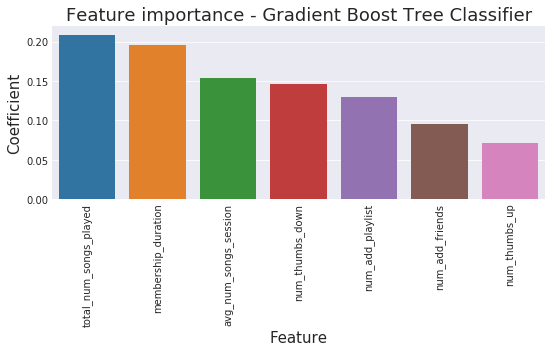

In [157]:
cvModel_gbt, results_gbt = build_model(training_data, validation_data, 'gbt')
df_f1_gbt, df_feature_importance_gbt = evalualte_model(cvModel_gbt, results_gbt)
plot_sns_bar(x='Feature',
             y='Coefficient', 
             data=df_feature_importance_gbt, 
             title='Feature importance - Gradient Boost Tree Classifier', 
             xlabel='Feature', 
             ylabel='Coefficient', 
             save=True, 
             hide_xtick=False,
             rotation=90,
             order=False)

In [154]:
printmd('#### Metrics - Gradient Boost Tree Model')
display(df_f1_gbt)

f1_gbt = df_f1_gbt['f1'].max()
maxIter_gbt = df_f1_gbt['maxIter'][df_f1_gbt['f1']==f1_gbt].values[0]
print('Best model f1 score: ', f1_gbt)
print('Best model maxIter: ', maxIter_gbt)

#### Metrics - Gradient Boost Tree Model

,f1,maxIter
0,0.736170,5
1,0.739778,8
2,0.736170,10


Best model f1 score:  0.73977812998
Best model maxIter:  8


### Result:
- Highest f1 score was achieved for maxIter=8. 
- The three most important features to predict **churn** are:
    - total_num_songs_played
    - membership_duration
    - avg_num_songs_session
 
#### most important tuning parameters
- **maxIter** - max number of iterations (>= 0). (default: 100)

### Further optimizations:
- Increase maxIter further (e.g. 20...50) 
- Use a larger dataset. 225 unique users is just a small subset.
- Implement further features for modeling

In [156]:
df_metric_result = pd.DataFrame({'f1 score': [f1_rf, f1_lr ,f1_gbt]},index=['RandomForestClassifier', 'LogisticRegression', 'GBTClassifier'])
df_metric_result


,f1 score
RandomForestClassifier,0.753723
LogisticRegression,0.706435
GBTClassifier,0.739778


In [ ]:
df_model.printSchema()

## <a class="anchor" id="evaluation">Evaluation</a>

### Main results:
- Three different models were tested and hyperparameters for classifiers and regression models were tuned
    - RandomForestClassifier
    - LogisticRegression
    - GBTClassifier
- The model was created by using Spark's Pipeline module and chaining input vectorization, minmax scaling and classification/regression.
- By using ParamGridBuilder different classifier/regression model hyperparameters were tuned, e.g. maximum number of iterations or number of trees.
- Via CrossValidator the differnt pipeline estimators were evaluated. Thereby The number of folds was fixed to 3. Maybe higher fold numbers could further optimize the result.
- By using MulticlassClassificationEvaluator a f1 score metric was implemented (default setting of MulticlassClassificationEvaluator). 
- As the dataset is small and churned and non-churned users are not evenly distributed the f1 score should be the best metric for predicting churn.
- **The highest f1 score** was achieved for the **RandomForestClassifer** approach. 
- Thereby the f1 score is highly sensitiv to the choice of hyperparameters. Hence it is believed, there is still room for optimizations. 
- All three models show that the duration of membership is a good feature in predicting churn. In all three moodels this feature has high feature importance values.


### Further optimizations:
- Tune the the hyperparameters of the corresponding classifier and regression models in a wider range.  However, take care about overfitting especially when tuning maxIter.
- Implement further hyperparameters (see above).
- Use a larger dataset. 225 unique users is just a small subset. It is believed that a transfer to the 12GB dataset could result in higher f1 scores. In addition, other metrics like accuracy could then be used as the binary label set (1 or 0) is more evenly distributed.
- Implement further features for modeling.
- Integrate other databases in order to link song names with genre. Maybe churned user may like to listen to a special kind of genre which is only weakly supported by Sparkify at the moment. This result could be also used as a baseline for a Recommendation Engine in future optimizations.


### What was difficult in this project:
- For me the most difficult part was getting good documentations with examples for special Spark modules like MulticlassClassificationEvaluator or GBTClassifier. It seems that Data Science community which uses Spark is still a small one compared to the Pandas or scikit-learn comunity for example.
- In the beginning I had difficulties to identify the 'listen to a song' service. It was not clear for me that this is connected to the web page 'NextSong'. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.